In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from matplotlib.ticker import PercentFormatter
from utils import *

In [2]:
t_start = 0                                     # Start day
t_end = 180                                     # End day
t_points = 500                                  # No. time points
t = np.linspace(t_start,t_end,t_points)         # Define time array
t_interval = (t_end - t_start)/(t_points-1)     # Calculate time interval

# Define viridis colour scheme
norm = Normalize(vmin=0, vmax=2)
colors = [viridis(norm(i)) for i in range(3)]

In [3]:
# Define population size
N = int(1e5)

# Initialise results arrays
results_passive = []
results_active = []
results_none = []
cumul_infections_passive = []
cumul_infections_active = []
cumul_infections_none = []

# Iterate through each individual in population
for i in range(N):
    ## Intranasally administered (passive) prophylactic treatment 
    # Define parameter values
    q_passive = 0.01
    R0 = 2
    p = 0.9
    gamma_m = 1/stats.truncnorm.rvs(a=0, b=1000, loc=4.4, scale=1.8)
    gamma_s = 1/np.random.lognormal(mean=1.1, sigma=0.75)
    epsilon_ss = np.random.normal(loc=0.66, scale=0.04)
    beta = R0*gamma_m*gamma_s/(p*gamma_s + (1-p)*gamma_m)
    beta_m = beta
    beta_m2 = beta
    beta_s = beta
    beta_s2 = beta
    a = 1/np.random.lognormal(mean=0.65, sigma=0.3)
    c = 0.75
    I_m0 = 1
    I_s0 = 0

    # Define initial conditions and parameter values
    y0_passive = [N-(I_m0 + I_s0), 0, 0, I_m0, I_s0, 0]
    k_passive = [q_passive, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon_ss, c, a, p, N]
    k_none = [0, beta_m, beta_m2, beta_s, beta_s2, gamma_m, gamma_s, epsilon_ss, c, a, p, N]

    # Solve ODEs
    y_passive = odeint(passive_model, y0_passive, t, args=(k_passive,))
    results_passive.append(y_passive)
    y_none = odeint(passive_model, y0_passive, t, args=(k_none,))
    results_none.append(y_none)

    ## Vaccination (active) treatment
    # Define parameter values
    q_active = q_passive
    q_v1 = 1/21
    q_v2 = 1/21
    beta_m = beta
    beta_v1m = beta
    beta_v2m = beta
    beta_s = beta
    beta_v1s = beta
    beta_v2s = beta
    epsilon_1 = 0.2*epsilon_ss
    epsilon_2 = epsilon_ss


    # Define initial conditions and parameter values
    y0_active = [N-1, 0, 0, 0, 0, I_m0, I_s0, 0]
    k_active = [q_active, q_v1, q_v2, beta_m, beta_v1m, beta_v2m, beta_s, beta_v1s, beta_v2s, gamma_m, gamma_s, epsilon_1, epsilon_2, c, a, p, N]

    # Solve ODEs
    y_active = odeint(active_model, y0_active, t, args=(k_active,))
    results_active.append(y_active)

    # Append results to array
    cumul_infections_passive.append(np.cumsum(a*y_passive[:,2]*t_interval))
    cumul_infections_active.append(np.cumsum(a*y_active[:,4]*t_interval))
    cumul_infections_none.append(np.cumsum(a*y_none[:,2]*t_interval))

In [4]:
# Convert to numpy array
cumul_infections_passive = np.array(cumul_infections_passive)
cumul_infections_active = np.array(cumul_infections_active)
cumul_infections_none = np.array(cumul_infections_none)

# Calculate number of infections averted by intranasal prophylaxis and vaccination
n_averted_passive = 1 - (cumul_infections_passive)/(cumul_infections_none)
n_averted_active = 1 - (cumul_infections_active)/(cumul_infections_none)

In [6]:
## Calculate the mean and 95% credible interval for each scenario

# Cumulative number of infections with vaccination
mean_active = np.mean(cumul_infections_active, axis=0)
perc25_active = np.percentile(cumul_infections_active, 2.5, axis=0)
perc975_active = np.percentile(cumul_infections_active, 97.5, axis=0)

# Cumulative number of infections with intranasal prophylaxis
mean_passive = np.mean(cumul_infections_passive, axis=0)
perc25_passive = np.percentile(cumul_infections_passive, 2.5, axis=0)
perc975_passive = np.percentile(cumul_infections_passive, 97.5, axis=0)

# Cumulative number of infections without intervention
mean_none = np.mean(cumul_infections_none, axis=0)
perc25_none = np.percentile(cumul_infections_none, 2.5, axis=0)
perc975_none = np.percentile(cumul_infections_none, 97.5, axis=0)

# Number of infections averted by vaccination
mean_averted_active = np.mean(n_averted_active, axis=0)
perc25_averted_active = np.percentile(n_averted_active, 2.5, axis=0)
perc975_averted_active = np.percentile(n_averted_active, 97.5, axis=0)

# Number of infections averted by intranasal prophylaxis
mean_averted_passive = np.mean(n_averted_passive, axis=0)
perc25_averted_passive = np.percentile(n_averted_passive, 2.5, axis=0)
perc975_averted_passive = np.percentile(n_averted_passive, 97.5, axis=0)

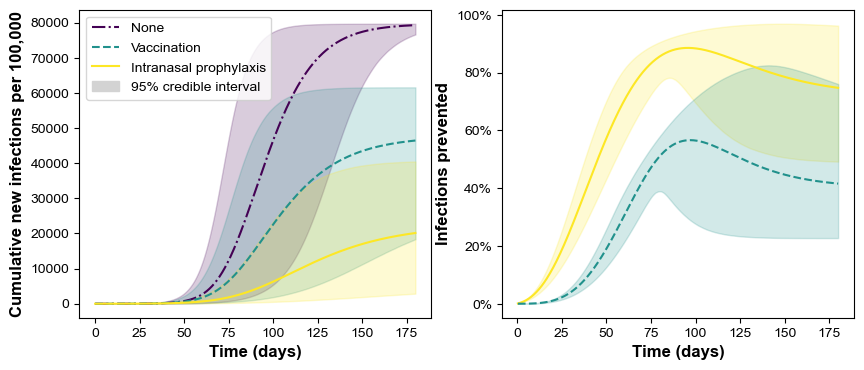

In [9]:
# Create a figure and axis
opacity = 0.2
plt.rcParams['font.family'] = 'Arial'

# Create figure and axes for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot
axs[0].fill_between(t, perc25_none, perc975_none, color=colors[0], alpha=opacity)
axs[0].plot(t, mean_none, label='None', color=colors[0], linestyle='dashdot')
axs[0].fill_between(t, perc25_active, perc975_active, color=colors[1], alpha=opacity)
axs[0].plot(t, mean_active, label='Vaccination', color=colors[1], linestyle='dashed')
axs[0].fill_between(t, perc25_passive, perc975_passive, color=colors[2], alpha=opacity)
axs[0].plot(t, mean_passive, label='Intranasal prophylaxis', color=colors[2])
axs[0].fill_between([np.nan, np.nan], [np.nan, np.nan], label='95% credible interval', color='lightgrey')
axs[0].set_xlabel('Time (days)', weight='bold', fontsize=12)
axs[0].set_ylabel('Cumulative new infections per 100,000', weight='bold', fontsize=12)
axs[0].legend(loc='upper left')

# Second subplot
axs[1].fill_between(t, perc25_averted_passive, perc975_averted_passive, color=colors[2], alpha=opacity)
axs[1].plot(t, mean_averted_passive, label='Intranasal prophylaxis', color=colors[2])
axs[1].fill_between(t, perc25_averted_active, perc975_averted_active, color=colors[1], alpha=opacity)
axs[1].plot(t, mean_averted_active, label='Vaccination', color=colors[1], linestyle='dashed')
axs[1].set_xlabel('Time (days)', weight='bold', fontsize=12)
axs[1].set_ylabel('Infections prevented', weight='bold', fontsize=12)
axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

In [12]:
fig.savefig("../figures/Figure1.svg", bbox_inches=0)